In [1]:
import pandas as pd
import datetime as dt
import swifter
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import copy
import pandas as pd
import swifter
import copy
import re
import os
import json

from pprint import pprint

# Functions

## HO Classify

In [2]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    
    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


## Measurement Report

In [3]:
class REPORTCONFIG:
    def __init__(self, name, parameter):
        self.name = name.split(' ')[0]  
        self.parameters = self.parse_parameter(parameter)
    
    def parse_parameter(self, parameter):
        L = []
        start = False
        for i in range(len(parameter)):
            if parameter[i] == "'" and start == False:
                s = ''
                start = True
                continue
            
            if start:
                if parameter[i] == "'":
                    L.append(s)
                    start = False
                s += parameter[i]
        
        P = dict()
        filter = '+-0123456789[]()&'
        for i in range(0,len(L),2):
            x = ''
            for c in L[i+1]:
                if c in filter:
                    x += c
            try:
                P[L[i]] = int(x)
            except:
                P[L[i]] = x
        return P
    
    def reset_name(self, name):
        self.name = name

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

class MEASOBJ:

    def __init__(self, obj, freq):
        self.name = obj
        self.freq = freq

    def __str__(self):
        return f'({self.name}, {self.freq})'

    def __repr__(self):
        return f'({self.name}, {self.freq})'

def parse_measIdToAddMod(s):
    a = s.replace('(','')
    a = a.replace(')','')
    a = a.split('&')
    return (a[0], a[1], a[2])


In [4]:
def MeasureReport(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()    
    cols_to_covert = ['measObjectId', 'carrierFreq', 'carrierFreq-r15', 'lte-reportConfigId', 'lte-measIdToRemoveList', 'measId', 'ssbFrequency']
    mi_rrc_df[cols_to_covert] = mi_rrc_df[cols_to_covert].astype('str')

    measobj_dict, report_config_dict, measId_dict = {}, {}, {}
    nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    def reset():

        global measobj_dict, report_config_dict, measId_dict, nr_measobj_dict, nr_report_config_dict, nr_measId_dict  
        measobj_dict, report_config_dict, measId_dict = {}, {}, {}
        nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    L = []

    RRC_connected = True
    Unknown = REPORTCONFIG('Unknown', {})

    for i in range(len(mi_rrc_df)):

        if mi_rrc_df['type_id'].iloc[i] == "5G_NR_RRC_OTA_Packet" or mi_rrc_df['type_id'].iloc[i] == "LTE_RRC_Serv_Cell_Info":
            continue

        time = mi_rrc_df['Timestamp'].iloc[i]
        others = ''
        
        # if mi_rrc_df["rrcConnectionRelease"].iloc[i] == 1:      
        #     reset()

        if mi_rrc_df["lte-measIdToRemoveList"].iloc[i] != '0':

            measIdToRemove_list = mi_rrc_df["lte-measIdToRemoveList"].iloc[i].split('@')
            if len(measIdToRemove_list) == 32:
                measId_dict = {}
            elif len(measId_dict) != 0:
                for a in range(len(measIdToRemove_list)):
                    try: measId_dict.pop(measIdToRemove_list[a])
                    except: pass

        if mi_rrc_df["lte-measurementReport"].iloc[i] == 1:
            
            others += 'E-UTRAN'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = measId_dict[id]
                event = report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)

            L.append(mr)

        if mi_rrc_df["nr-measurementReport"].iloc[i] == 1:
            
            others += 'NR'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = nr_measId_dict[id]
                event = nr_report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)
            
            L.append(mr)

        if mi_rrc_df["lte-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            carrierFreq_list = mi_rrc_df["carrierFreq"].iloc[i].split('@')
            carrierFreq_r15_list = mi_rrc_df["carrierFreq-r15"].iloc[i].split('@')
            
            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectEUTRA (0)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_list[0])
                    carrierFreq_list.pop(0)
                elif measobj_list[a] == "measObjectNR-r15 (5)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_r15_list[0])
                    carrierFreq_r15_list.pop(0)
    

        if mi_rrc_df["nr-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            ssbFrequency_list = mi_rrc_df["ssbFrequency"].iloc[i].split('@')

            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectNR (0)":
                    nr_measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], ssbFrequency_list[0])
                    ssbFrequency_list.pop(0)     

            
        if mi_rrc_df["lte-ReportConfigToAddMod"].iloc[i] == 1:

            reportConfigId_list = mi_rrc_df["lte-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["lte-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["lte-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])


        if mi_rrc_df["nr-ReportConfigToAddMod"].iloc[i] == 1: #############

            reportConfigId_list = mi_rrc_df["nr-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["nr-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["nr-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                nr_report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])

        if mi_rrc_df["lte-MeasIdToAddMod"].iloc[i] != '0':

            MeasIdToAdd_list = mi_rrc_df["lte-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                measId_dict[x[0]] = (x[1],x[2])


        if mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != '0' and mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != 0:

            MeasIdToAdd_list = mi_rrc_df["nr-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                nr_measId_dict[x[0]] = (x[1],x[2])

    # Sort to Dict
    types = ['eventA1','eventA2','E-UTRAN-eventA3', 'eventA5', 'eventA6','NR-eventA3', 'eventB1-NR-r15','reportCGI', 'reportStrongestCells', 'others']
    D = {k: [] for k in types}

    for mr in L:

        if 'E-UTRAN' in mr.others and 'eventA1' in mr.event.name:
            D['eventA1'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA2' in mr.event.name:
            D['eventA2'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventA3' in mr.event.name:
            D['E-UTRAN-eventA3'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA5' in mr.event.name:
            D['eventA5'].append(mr)

        elif 'E-UTRAN' in mr.others and 'eventA6' in mr.event.name:
            D['eventA6'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventB1-NR-r15' in mr.event.name:
            D['eventB1-NR-r15'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportCGI' in mr.event.name:
            D['reportCGI'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportStrongestCells' in mr.event.name:
            D['reportStrongestCells'].append(mr)
        
        elif 'NR' in mr.others and 'eventA3' in mr.event.name:
            D['NR-eventA3'].append(mr)       
        
        else:
            D['others'].append(mr)

    return D

## Map MeasureReport with HO

In [5]:
def map_MR_HO(MRs, HOs):

    map_ho_types = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', ]
    map_mr_types = ['E-UTRAN-eventA3', 'eventA5', 'eventB1-NR-r15', 'NR-eventA3']

    D = {'LTE_HO': [], 'NR_HO': [], 'SN_setup': []}

    for lte_ho_type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB']:
        for ho in HOs[lte_ho_type]:
            for mr_type in ['E-UTRAN-eventA3', 'eventA5']:
                
                for mr in MRs[mr_type]:
                    # The current mapping way may map a HO with repeated measurement report.
                    dif = (ho.start - mr.time).total_seconds()
                    if 0 < dif < 0.5:
                        D['LTE_HO'].append((mr, ho, lte_ho_type))

    for nr_ho_type in ['SN_Rel', 'SN_HO']:
        for ho in HOs[nr_ho_type]:
            for mr in MRs['NR-eventA3']:

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5:
                    D['NR_HO'].append((mr, ho, nr_ho_type))

    for ho in HOs['SN_setup']:
        for mr in MRs['eventB1-NR-r15']:

            dif = (ho.start - mr.time).total_seconds()
            if 0 < dif < 0.5:
                D['SN_setup'].append((mr, ho, 'SN_setup'))

    return D 
                

In [6]:
# Correct MR with HO
def correct_MR_with_HO(MRs, HOs):
    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    new_MRs = copy.deepcopy(MRs)
    del new_MRs['others']

    for mr in MRs['others']:
        if 'E-UTRAN' in mr.others:
            for ho in HOs['LTE_HO'] + HOs['MN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['E-UTRAN-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
        elif 'NR' in mr.others:
            for ho in HOs['SN_HO']:
                if 0.3 > (ho.start - mr.time).total_seconds() > 0:
                    mr.event.reset_name('eventA3')
                    new_MRs['NR-eventA3'].append(MR(time = mr.time, event = mr.event, others = mr.others))
    
    return new_MRs                

## UE State

In [7]:
def UE_state(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()

## HO Trace

In [8]:
# For colored output text
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_trans(HOs, p=True, mappings=None):

    All_HOs = []
    selected = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', 
    'Conn_Req' ,'RLF_II', 'RLF_III', 'SCG_RLF']

    def find_mr(target, ho):
        for mapping in target:
            map_ho = mapping[1]
            if ho == map_ho:
                mr = mapping[0]
                return mr
        return None

    for type in selected:

        for ho in HOs[type]:

            if type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'] and mappings is not None:
            
                target = mappings['LTE_HO']
                mr = find_mr(target, ho)
                
                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_Rel', 'SN_HO'] and mappings is not None:
            
                target = mappings['NR_HO']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_setup'] and mappings is not None:
            
                target = mappings['SN_setup']
                mr = find_mr(target, ho)

                if mr is not None and 0 < (ho.start - mr.time).total_seconds() < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])
                
            else:
                All_HOs.append([type, ho])

    All_HOs = sorted(All_HOs, key = lambda x: x[1].start)

    if p:
        for ho in All_HOs:
            if len(ho) == 3:
                print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC} | {bcolors.OKGREEN}{ho[2].event.name}{bcolors.ENDC} | {ho[2].event.parameters}')
            elif len(ho) == 2:
                print(f'{ho[1].start} | {bcolors.OKBLUE}{ho[0]}{bcolors.ENDC} | {bcolors.OKCYAN}{ho[1].trans}{bcolors.ENDC}')

    return All_HOs

## Loss/Excl

In [9]:
def loss_excl_cause(loss_lat_file_path, rrc_file_path):

    loss_lat_df = pd.read_csv(loss_lat_file_path)

    loss_cond = loss_lat_df['lost'] == True
    loss_packets = loss_lat_df[loss_cond]
    loss_packets = loss_packets.reset_index(drop=True)
    loss_packets['Timestamp'] = pd.to_datetime(loss_packets['Timestamp'])

    exc_lat = 0.1
    excl_cond = (loss_cond==False) & (loss_lat_df['latency'] > exc_lat)
    excl_packets = loss_lat_df[excl_cond]
    excl_packets = excl_packets.reset_index(drop=True)
    excl_packets['Timestamp'] = pd.to_datetime(excl_packets['Timestamp'])

    HO_dict = parse_mi_ho(rrc_file_path)
    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    LOSS_PKT = namedtuple('LOSS_PKT',['timestamp', 'seq', 'cause', 'trans', 'trans_time', 'others'], defaults=['', 0, [], [], [], []])

    LOSS_PKTs = []

    for i in range(len(loss_packets)):

        loss_packet = loss_packets.iloc[i]
        loss_packet_timestamp = loss_packet['Timestamp']
        seq = loss_packet['seq']
        
        cause = []
        trans = []
        others = []
        trans_time = []

        for HO_type, slot in zip(events, slots):
            
            HOs = HO_dict[HO_type]  

            for h in HOs:
                
                if h.start - slot < loss_packet_timestamp < h.start:
                    cause.append(f'Before {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.start)
                    others.append(h.others)
                elif (h.end is not None) and (h.start < loss_packet_timestamp < h.end):
                    cause.append(f'During {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append((h.start, h.end))
                    others.append(h.others)
                elif (h.end is not None) and (h.end < loss_packet_timestamp < h.end + slot):
                    cause.append(f'After {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.end)
                    others.append(h.others)

        LOSS_PKTs.append(LOSS_PKT(timestamp=loss_packet_timestamp, seq=seq, cause=cause, others=others))
                
    EXCL_PKT = namedtuple('EXCL_PKT',['timestamp', 'seq', 'cause', 'trans', 'trans_time', 'others'], defaults=['', 0, [], [], [], []])

    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1)]
    
    EXCL_PKTs = []

    for i in range(len(excl_packets)):

        excl_packet = excl_packets.iloc[i]
        excl_packet_timestamp = excl_packet['Timestamp']
        seq = excl_packet['seq']

        cause = []
        trans = []
        trans_time = []
        others = []

        for HO_type, slot in zip(events, slots):
            
            HOs = HO_dict[HO_type]   
            for h in HOs:
                
                if h.start - slot < excl_packet_timestamp < h.start:
                    cause.append(f'Before {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.start)
                    others.append(h.others)
                elif (h.end is not None) and (h.start < excl_packet_timestamp < h.end):
                    cause.append(f'During {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append((h.start, h.end))
                    others.append(h.others)
                elif (h.end is not None) and (h.end < excl_packet_timestamp < h.end + slot):
                    cause.append(f'After {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.end)
                    others.append(h.others)

        EXCL_PKTs.append(EXCL_PKT(timestamp=excl_packet_timestamp, seq=seq, cause=cause, trans=trans, trans_time=trans_time, others=others))
    
    return LOSS_PKTs, EXCL_PKTs

In [10]:
def loss_excl_cause_dual(loss_lat_file_path1, loss_lat_file_path2, rrc_file_path1, rrc_file_path2):

    df1 = pd.read_csv(loss_lat_file_path1)
    df2 = pd.read_csv(loss_lat_file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)

    loss_packets1 = df1[loss_cond]
    loss_packets1 = loss_packets1.reset_index(drop=True)
    loss_packets1['Timestamp'] = pd.to_datetime(loss_packets1['Timestamp'])

    loss_packets2 = df2[loss_cond]
    loss_packets2 = loss_packets2.reset_index(drop=True)
    loss_packets2['Timestamp'] = pd.to_datetime(loss_packets2['Timestamp'])

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1 
    excl_cond1 = (loss_cond==False) & (df1['latency'] > exc_lat)
    excl_cond2 = (loss_cond==False) & (df2['latency'] > exc_lat)
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    
    excl_packets1 = df1[excl_cond]
    excl_packets1 = excl_packets1.reset_index(drop=True)
    excl_packets1['Timestamp'] = pd.to_datetime(excl_packets1['Timestamp'])

    excl_packets2 = df2[excl_cond]
    excl_packets2 = excl_packets2.reset_index(drop=True)
    excl_packets2['Timestamp'] = pd.to_datetime(excl_packets2['Timestamp'])

    HO_dict1 = parse_mi_ho(rrc_file_path1)
    HO_dict2 = parse_mi_ho(rrc_file_path2)
    
    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    LOSS_PKT_DUAL = namedtuple('LOSS_PKT_DUAL',
                               ['timestamp1', 'timestamp2', 'seq', 'cause1', 'cause2', 'trans1', 'trans2', 'others1', 'others2','trans1_time', 'trans2_time'], 
                               defaults=['', '', 0, [], [], [], [], [], [], [], []])

    LOSS_PKT_DUALs = []

    for i in range(len(loss_packets1)):

        loss_packet1 = loss_packets1.iloc[i]
        loss_packet1_timestamp = loss_packet1['Timestamp']

        loss_packet2 = loss_packets2.iloc[i]
        loss_packet2_timestamp = loss_packet2['Timestamp']

        seq = loss_packet1['seq']
        
        cause1, cause2 = [], []
        trans1, trans2 = [], []
        others1, others2 = [], []
        trans1_time, trans2_time = [], []

        for HO_type, slot in zip(events, slots):
            
            HOs1 = HO_dict1[HO_type]
            HOs2 = HO_dict2[HO_type]   

            for h in HOs1:
                
                if h.start - slot < loss_packet1_timestamp < h.start:
                    cause1.append(f'Before {HO_type}') 
                    trans1.append(h.trans)
                    trans1_time.append(h.start)
                    others1.append(h.others)

                elif (h.end is not None) and (h.start < loss_packet1_timestamp < h.end):
                    cause1.append(f'During {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append((h.start, h.end))
                    others1.append(h.others)

                elif (h.end is not None) and (h.end < loss_packet1_timestamp < h.end + slot):
                    cause1.append(f'After {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append(h.end)
                    others1.append(h.others)
            
            for h in HOs2:
                
                if h.start - slot < loss_packet2_timestamp < h.start:
                    cause2.append(f'Before {HO_type}') 
                    trans2.append(h.trans)
                    trans2_time.append(h.start)
                    others2.append(h.others)

                elif (h.end is not None) and (h.start < loss_packet2_timestamp < h.end):
                    cause2.append(f'During {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append((h.start, h.end))
                    others2.append(h.others)

                elif (h.end is not None) and (h.end < loss_packet2_timestamp < h.end + slot):
                    cause2.append(f'After {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append(h.end)
                    others2.append(h.others)
    
        LOSS_PKT_DUALs.append(LOSS_PKT_DUAL(timestamp1=loss_packet1_timestamp, timestamp2=loss_packet2_timestamp, seq=seq, 
        cause1=cause1, cause2=cause2, trans1=trans1, trans2=trans2, others1=others1, others2=others2, trans1_time=trans1_time, trans2_time=trans2_time))
                
    slot = dt.timedelta(seconds=2)
    EXCL_PKT_DUAL = namedtuple('EXCL_PKT_DUAL',
                               ['timestamp1', 'timestamp2', 'seq', 'cause1', 'cause2', 'trans1', 'trans2', 'others1', 'others2','trans1_time', 'trans2_time'], 
                               defaults=['', '', 0, [], [], [], [], [], [], [], []])

    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    
    EXCL_PKT_DUALs = []

    for i in range(len(excl_packets1)):

        excl_packet1 = excl_packets1.iloc[i]
        excl_packet1_timestamp = excl_packet1['Timestamp']
        excl_packet2 = excl_packets2.iloc[i]
        excl_packet2_timestamp = excl_packet2['Timestamp']

        seq = excl_packet1['seq']

        cause1, cause2 = [], []
        trans1, trans2 = [], []
        others1, others2 = [], []
        trans1_time, trans2_time = [], []

        for HO_type, slot in zip(events, slots):
            
            HOs1 = HO_dict1[HO_type]
            HOs2 = HO_dict2[HO_type]

            for h in HOs1:
                
                if h.start - slot < excl_packet1_timestamp < h.start:
                    cause1.append(f'Before {HO_type}') 
                    trans1.append(h.trans)
                    trans1_time.append(h.start)
                    others1.append(h.others)

                elif (h.end is not None) and (h.start < excl_packet1_timestamp < h.end):
                    cause1.append(f'During {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append((h.start, h.end))
                    others1.append(h.others)

                elif (h.end is not None) and (h.end < excl_packet1_timestamp < h.end + slot):
                    cause1.append(f'After {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append(h.end)
                    others1.append(h.others)

            for h in HOs2:
                
                if h.start - slot < excl_packet2_timestamp < h.start:
                    cause2.append(f'Before {HO_type}') 
                    trans2.append(h.trans)
                    trans2_time.append(h.start)
                    others2.append(h.others)

                elif (h.end is not None) and (h.start < excl_packet2_timestamp < h.end):
                    cause2.append(f'During {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append((h.start, h.end))
                    others2.append(h.others)

                elif (h.end is not None) and (h.end < excl_packet2_timestamp < h.end + slot):
                    cause2.append(f'After {HO_type}')
                    trans2.append(h.trans)                   
                    trans2_time.append(h.end)
                    others2.append(h.others)

        EXCL_PKT_DUALs.append(EXCL_PKT_DUAL(timestamp1=excl_packet1_timestamp, timestamp2=excl_packet2_timestamp, seq=seq, 
        cause1=cause1, cause2=cause2, trans1=trans1, trans2=trans2, others1=others1, others2=others2, trans1_time=trans1_time, trans2_time=trans2_time))

    return LOSS_PKT_DUALs, EXCL_PKT_DUALs

## Signal Strength

### LTE RSRP/RSRQ

In [11]:
SS = namedtuple('SS', ['PCI', 'earfcn', 'RSRP', 'RSRQ', 'Timestamp'], defaults=['','',0,0,None])

def LTE_signal_strength(ml1_file, time_range):
    # Read csv with pandas
    ml1_df = pd.read_csv(ml1_file)
    ml1_df['Timestamp'] = pd.to_datetime(ml1_df['Timestamp'])
    ml1_df['Timestamp'] = ml1_df['Timestamp'] + pd.Timedelta(hours=8)
    ml1_df = ml1_df.astype({'PCI': str, 'EARFCN': str})

    # Read ml1 csv data
    Cells = {}
    PCell = []
    SCell1, SCell2, SCell3 = [], [], []

    start_time = time_range[0]
    end_time = time_range[1]

    for i in range(len(ml1_df)):

        t = ml1_df['Timestamp'].iloc[i]
        if t < start_time: continue
        elif start_time <= t < end_time: pass
        elif end_time <= t: break

        serv_cell_idx = ml1_df['Serving Cell Index'].iloc[i]
        pci = ml1_df['PCI'].iloc[i]
        earfcn = ml1_df['EARFCN'].iloc[i]
        rsrp = ml1_df['RSRP(dBm)'].iloc[i]
        rsrq = ml1_df['RSRQ(dB)'].iloc[i]

        ss = SS(pci, earfcn, rsrp, rsrq, t)
        
        if serv_cell_idx == 'PCell':
            PCell.append(ss)
        elif serv_cell_idx == '1_SCell':
            SCell1.append(ss)
        elif serv_cell_idx == '2_SCell':
            SCell2.append(ss)
        elif serv_cell_idx == '(MI)Unknown':
            SCell3.append(ss)

        k = pci+' '+earfcn 
        if k in Cells.keys():
            Cells[k].append(ss)
        else:
            Cells[k] = [ss]

        # Cells
        num_neicells = ml1_df['Number of Neighbor Cells'].iloc[i]
        
        for j in np.arange(9, 9+num_neicells*3,3):
            pci = str(int(ml1_df.iloc[i][j]))
            rsrp = ml1_df.iloc[i][j+1]
            rsrq = ml1_df.iloc[i][j+2]
            ss = SS(pci, earfcn, rsrp, rsrq, t)
            k = pci+' '+earfcn 

            if k in Cells.keys():
                Cells[k].append(ss)
            else:
                Cells[k] = [ss]
    
    return PCell, SCell1, SCell2, SCell3, Cells

### NR RSRP/RSRQ

In [12]:
SS = namedtuple('SS', ['PCI', 'earfcn', 'RSRP', 'RSRQ', 'Timestamp'], defaults=['','',0,0,None])

def NR_signal_strength(ml1_file, time_range):
    # Read csv with pandas
    ml1_df = pd.read_csv(ml1_file)
    ml1_df['Timestamp'] = pd.to_datetime(ml1_df['Timestamp'])
    ml1_df['Timestamp'] = ml1_df['Timestamp'] + pd.Timedelta(hours=8)
    ml1_df = ml1_df.astype({'Serving Cell PCI': str, 'Raster ARFCN': str})

    Cells = {}
    PSCell = []

    start_time = time_range[0]
    end_time = time_range[1]

    for i in range(len(ml1_df)):

        t = ml1_df['Timestamp'].iloc[i]
        if t < start_time: continue
        elif start_time <= t < end_time: pass
        elif end_time <= t: break

        PSCell_pci = ml1_df['Serving Cell PCI'].iloc[i]
        earfcn = ml1_df['Raster ARFCN'].iloc[i]

        # Deal with Cells first        
        for j in np.arange(6, len(ml1_df.columns),3):
            if np.isnan(ml1_df.iloc[i][j]):
                break
            pci = str(int(ml1_df.iloc[i][j]))
            rsrp = ml1_df.iloc[i][j+1]
            rsrq = ml1_df.iloc[i][j+2]
            ss = SS(pci, earfcn, rsrp, rsrq, t)
            k = pci+' '+earfcn 

            if k in Cells.keys():
                Cells[k].append(ss)
            else:
                Cells[k] = [ss]

        # Deal with PSCell
        if PSCell_pci == '65535':
            continue
        ss = Cells[PSCell_pci+' '+earfcn][-1]
        PSCell.append(ss)
        
    
    return PSCell, Cells

# Main

## Visualized

In [144]:
# Get names of files
date = '2024-01-08'
exp = 'Modem_Action_Test_v2_1'
trace = '#01'

base_dir = '/home/wmnlab/D/database'
date_dir = os.path.join(base_dir, date)
d = os.path.join(date_dir, exp)
devs = sorted([a for a in os.listdir(d) if ('qc' in a or 'sm' in a)])
data_dir1 = os.path.join(d, devs[0], trace, 'data')
data_dir2 = os.path.join(d, devs[1], trace, 'data')
rrc_file1 = [os.path.join(data_dir1, f) for f in os.listdir(data_dir1) if 'rrc' in f][0]
rrc_file2 = [os.path.join(data_dir2, f) for f in os.listdir(data_dir2) if 'rrc' in f][0]
ml1_file1 = [os.path.join(data_dir1, f) for f in os.listdir(data_dir1) if ('ml1' in f and not 'nr_ml1' in f)][0]
ml1_file2 = [os.path.join(data_dir2, f) for f in os.listdir(data_dir2) if ('ml1' in f and not 'nr_ml1' in f)][0]
nr_ml1_file1 = [os.path.join(data_dir1, f) for f in os.listdir(data_dir1) if 'nr_ml1' in f][0]
nr_ml1_file2 = [os.path.join(data_dir2, f) for f in os.listdir(data_dir2) if 'nr_ml1' in f][0]

In [145]:
rrc_file1, rrc_file2, ml1_file1, ml1_file2, nr_ml1_file1, nr_ml1_file2

('/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2024-1-8_15-40-53_rrc.csv',
 '/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc01/#01/data/diag_log_qc01_2024-1-8_15-40-53_rrc.csv',
 '/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2024-1-8_15-40-53_ml1.csv',
 '/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc01/#01/data/diag_log_qc01_2024-1-8_15-40-53_ml1.csv',
 '/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2024-1-8_15-40-53_nr_ml1.csv',
 '/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc01/#01/data/diag_log_qc01_2024-1-8_15-40-53_nr_ml1.csv')

In [146]:
HOs = parse_mi_ho(rrc_file1)
MRs = MeasureReport(rrc_file1)
MRs = correct_MR_with_HO(MRs, HOs)
mappings = map_MR_HO(MRs, HOs)
ordered_HOs1 = print_trans(HOs, mappings=mappings)

2024-01-08 15:41:27.695479 | SN_HO | (178, 3050) | O -> 122 | eventA3 | {}
2024-01-08 15:41:29.197768 | MN_HO_to_eNB | (178, 3050) -> (122, 3050) | 122 -> O | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:29.495683 | SN_setup | (122, 3050) | O -> 122 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-01-08 15:41:38.295545 | MN_HO_to_eNB | (122, 3050) -> (130, 3050) | 122 -> O | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:38.620036 | SN_setup | (130, 3050) | O -> 130 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-01-08 15:41:48.121521 | SN_HO | (130, 3050) | 130 -> 386 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-01-08 15:41:51.172632 | MN_HO | (130, 3050) -> (55, 3050) | 386 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:52.338365 | SN_HO | (55, 3050) | 386 -> 55 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-01-08 15:41:53.074486 | MN_HO | (55, 3050) -> (6, 3050) | 55 | eventA3 | {'off': 2, 'h

In [147]:
HOs = parse_mi_ho(rrc_file2)
MRs = MeasureReport(rrc_file2)
MRs = correct_MR_with_HO(MRs, HOs)
mappings = map_MR_HO(MRs, HOs)
ordered_HOs2 = print_trans(HOs, mappings=mappings)

2024-01-08 15:41:26.362554 | LTE_HO | (178, 3050) -> (122, 3050) | O | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:26.652885 | SN_setup | (122, 3050) | O -> 122 | eventB1-NR-r15 | {'thr': '[-111&-110)', 'hys': 0, 'ttt': 100}
2024-01-08 15:41:37.644029 | MN_HO | (122, 3050) -> (130, 3050) | 122 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:38.495326 | SN_HO | (130, 3050) | 122 -> 130 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-01-08 15:41:49.557133 | SN_HO | (130, 3050) | 130 -> 55 | eventA3 | {'off': 6, 'hys': 1, 'ttt': 640}
2024-01-08 15:41:51.132514 | MN_HO | (130, 3050) -> (55, 3050) | 55 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:52.017500 | MN_HO | (55, 3050) -> (6, 3050) | 55 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:53.726269 | MN_HO | (6, 3050) -> (130, 3050) | 55 | eventA3 | {'off': 2, 'hys': 1, 'ttt': 160}
2024-01-08 15:41:54.486319 | SN_HO | (130, 3050) | 55 -> 130 | eventA3 | {'off': 6, 'hys': 1, '

In [148]:
dl_loss_excl_file1 = os.path.join(data_dir1, 'udp_dnlk_loss_latency.csv')
dl_loss_excl_file2 = os.path.join(data_dir2, 'udp_dnlk_loss_latency.csv')
dl_loss1, dl_excl1 = loss_excl_cause(dl_loss_excl_file1, rrc_file1)
dl_loss2, dl_excl2 = loss_excl_cause(dl_loss_excl_file2, rrc_file2)
dl_loss, dl_excl = loss_excl_cause_dual(dl_loss_excl_file1, dl_loss_excl_file2, rrc_file1, rrc_file2)

In [149]:
ul_loss_excl_file1 = os.path.join(data_dir1, 'udp_uplk_loss_latency.csv')
ul_loss_excl_file2 = os.path.join(data_dir2, 'udp_uplk_loss_latency.csv')
ul_loss1, ul_excl1 = loss_excl_cause(ul_loss_excl_file1, rrc_file1)
ul_loss2, ul_excl2 = loss_excl_cause(ul_loss_excl_file2, rrc_file2)
ul_loss, ul_excl = loss_excl_cause_dual(ul_loss_excl_file1, ul_loss_excl_file2, rrc_file1, rrc_file2)

In [150]:
# Read time sync file
time_sync_file = [os.path.join(date_dir, x) for x in os.listdir(date_dir) if x.endswith('.json') and 'time_sync' in x][0]
print(time_sync_file)
with open(time_sync_file, 'r') as f:
    time_off_dict = json.load(f)

pattern = r'(\d{4}-\d+-\d+_\d{2}-\d{2}-\d{2})'
match = re.search(pattern, rrc_file1)
if match:
    datetime_str = match.group(1)
    filetime = pd.to_datetime(datetime_str, format='%Y-%m-%d_%H-%M-%S')
else:
    print("File Name Error!"); raise

measure_times = [pd.to_datetime(k, format='%Y-%m-%d %H:%M:%S.%f') for k in time_off_dict.keys()]
time_diffs = [abs(t-filetime) for t in measure_times]
ind, value = min(enumerate(time_diffs), key=lambda x: x[1])
print('rrc file time:', filetime,'; diff:',value)
delta = dt.timedelta(seconds=list(time_off_dict.values())[ind])
print('Sync Time:', list(time_off_dict.keys())[ind], '; delta',list(time_off_dict.values())[ind])

/home/wmnlab/D/database/2024-01-08/time_sync_lpt3.json
rrc file time: 2024-01-08 15:40:53 ; diff: 0 days 00:00:01.325901
Sync Time: 2024-01-08 15:40:54.325901 ; delta 0.006103799841498251


In [151]:
def find_longest_common_substring_length(str1, str2):
    len1 = len(str1)
    len2 = len(str2)

    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    max_length = 0  

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                max_length = max(max_length, dp[i][j])

    return max_length

In [152]:
# Read TimeSync csv
dev_dir = os.path.join(date_dir, 'others/TimeSync', devs[0])
files = os.listdir(dev_dir)
value = max(files, key = lambda x: find_longest_common_substring_length(x, rrc_file1))
ind = files.index(value)
TimeSync_file1 = os.path.join(dev_dir, files[ind])

dev_dir = os.path.join(date_dir, 'others/TimeSync', devs[1])
files = os.listdir(dev_dir)
value = max(files, key = lambda x: find_longest_common_substring_length(x, rrc_file2))
ind = files.index(value)
TimeSync_file2 = os.path.join(dev_dir, files[ind])

print(rrc_file1, TimeSync_file1, rrc_file2, TimeSync_file2, sep='\n')

TS_df1 = pd.read_csv(TimeSync_file1)
TS_df1['cell time'] = pd.to_datetime(TS_df1['cell time']) + dt.timedelta(hours=8)
TS_df1['device time'] = pd.to_datetime(TS_df1['device time'])

TS_df2 = pd.read_csv(TimeSync_file2)
TS_df2['cell time'] = pd.to_datetime(TS_df2['cell time']) + dt.timedelta(hours=8)
TS_df2['device time'] = pd.to_datetime(TS_df2['device time'])

/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2024-1-8_15-40-53_rrc.csv
/home/wmnlab/D/database/2024-01-08/others/TimeSync/qc00/TimeSync_qc00_2024-1-8_15-40-53.csv
/home/wmnlab/D/database/2024-01-08/Modem_Action_Test_v2_1/qc01/#01/data/diag_log_qc01_2024-1-8_15-40-53_rrc.csv
/home/wmnlab/D/database/2024-01-08/others/TimeSync/qc01/TimeSync_qc01_2024-1-8_15-40-53.csv


In [153]:
# Functions input ordered_HOs and output ordered_HOs with revised ho time align to server time 
def ho_time_to_server_time(ordered_HOs, TS_df):

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])

    i = 0
    ordered_HOs_ = []
    for elements in ordered_HOs:
        if len(elements) == 3:
            Type, ho, mr = elements[0], elements[1], elements[2]
        else:
            Type, ho = elements[0], elements[1]

        while i != len(TS_df)-1:
            diff = (TS_df['cell time'].iloc[i]  - ho.start).total_seconds()
            diff_ = (TS_df['cell time'].iloc[i+1]  - ho.start).total_seconds()
            if abs(diff) < abs(diff_):
                # device time + delta = server time; server time - cell time = server cell delta
                server_cell_delta = TS_df['device time'].iloc[i] + delta - TS_df['cell time'].iloc[i]
                ho_ = HO(start=ho.start+server_cell_delta, end=ho.end+server_cell_delta, others=ho.others, trans=ho.trans)
                if len(elements) == 3:
                    ordered_HOs_.append([Type, ho_, mr])
                else:
                    ordered_HOs_.append([Type, ho_])
                break
            i+=1
    return ordered_HOs_

# Functions input ordered_HOs and output ordered_HOs with revised ho time align to client time 
def ho_time_to_client_time(ordered_HOs, TS_df):

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])

    i = 0
    ordered_HOs_ = []
    for elements in ordered_HOs:
        if len(elements) == 3:
            Type, ho, mr = elements[0], elements[1], elements[2]
        else:
            Type, ho = elements[0], elements[1]

        while i != len(TS_df)-1:
            diff = (TS_df['cell time'].iloc[i]  - ho.start).total_seconds()
            diff_ = (TS_df['cell time'].iloc[i+1]  - ho.start).total_seconds()
            if abs(diff) < abs(diff_):
                # device time - cell time = client cell delta
                client_cell_delta = TS_df['device time'].iloc[i] - TS_df['cell time'].iloc[i]
                ho_ = HO(start=ho.start+client_cell_delta, end=ho.end+client_cell_delta, others=ho.others, trans=ho.trans)
                if len(elements) == 3:
                    ordered_HOs_.append([Type, ho_, mr])
                else:
                    ordered_HOs_.append([Type, ho_])
                break
            i+=1
    return ordered_HOs_

In [154]:
# Align ordered_HOs HO time to server time
ordered_HOs1_ = ordered_HOs1 # store previous value
ordered_HOs2_ = ordered_HOs2 # store previous value
ordered_HOs1 = ho_time_to_server_time(ordered_HOs1, TS_df1)
ordered_HOs2 = ho_time_to_server_time(ordered_HOs2, TS_df2)

In [155]:
# Useful Functions
def get_info(ordered_HOs, time_range):

    T, Type, Trans, Ev = [], [], [], []
    for element in ordered_HOs:
        NO_MR = False
        try:
            type, ho, mr = element[0], element[1], element[2]
        except:
            type, ho = element[0], element[1]
            NO_MR = True

        if ho.start < time_range[0]:
            continue
        elif time_range[1] < ho.start:
            break
        else: # in time range
            type = type.replace("_", " ")
            
            T.append(ho.start)
            Type.append(type)
            Trans.append(ho.trans)
            if NO_MR:
                Ev.append(mr.event)
            else:
                Ev.append(None)
    
    return T, Type, Trans, Ev

patterns = {
    'eNB HO': r'\((\d+), (\d+)\) -> \((\d+), (\d+)\)',
    'gNB HO': r'(\d+) -> (\d+)',
    'gNB setup': r'O -> (\d+)',
    'gNB rel':r'\((\d+), (\d+)\) \| (\d+) -> O' 
    }
def get_pci(string, type):
    pattern = patterns[type]
    match = re.match(pattern, string)

    if match:
        if type == 'eNB HO':
            return f'{match.group(1)}\u2192{match.group(3)}'
        elif type == 'gNB HO':
            return f'{match.group(1)}\u2192{match.group(2)}'
        elif type == 'gNB setup':
            return f'{match.group(1)}'
        elif type == 'gNB rel':
            return f'{match.group(3)}\u2192N/A'
    return None

In [156]:
from matplotlib import dates

# Choose Style
# 'classic', 'ggplot', 'seaborn', 'Solarize_Light2', 'bmh', 'fivethirtyeight', 'dark_background', 'grayscale',  
plt.style.use('default')

start_time = dt.datetime(2024, 1, 8, 15, 42, 8, 000000)
end_time = dt.datetime(2024, 1, 8, 15, 42, 15, 000000)
time_range = (start_time, end_time)

R1_PCell, R1_SCell1, R1_SCell2, R1_SCell3, R1_Cells = LTE_signal_strength(ml1_file1, time_range)
R2_PCell, R2_SCell1, R2_SCell2, R2_SCell3, R2_Cells = LTE_signal_strength(ml1_file2, time_range)

R1_PSCell, R1_NR_Cells = NR_signal_strength(nr_ml1_file1, time_range)
R2_PSCell, R2_NR_Cells = NR_signal_strength(nr_ml1_file2, time_range)

In [157]:
# Functions input ss output ss with revised time align to server time 
def ss_time_to_server_time(Cell, TS_df):
    i = 0
    Cell_ = []
    for ss in Cell:
    
        while i != len(TS_df)-1:
            
            diff = (TS_df['cell time'].iloc[i]  - ss.Timestamp).total_seconds()
            diff_ = (TS_df['cell time'].iloc[i+1]  - ss.Timestamp).total_seconds()
            if abs(diff) < abs(diff_):
                # device time + delta = server time; server time - cell time = server cell delta
                server_cell_delta = TS_df['device time'].iloc[i] + delta - TS_df['cell time'].iloc[i]
                ss_ = SS(PCI=ss.PCI, earfcn=ss.earfcn, RSRP=ss.RSRP, RSRQ=ss.RSRQ, Timestamp=ss.Timestamp+server_cell_delta)
                Cell_.append(ss_)
                break
            i+=1
    return Cell_

# Use the first delta only
def ss_time_to_server_time_way2(Cell, TS_df):
    # Calculate delta for middle data
    if len(Cell) == 0:
        return []
    ss = Cell[-1]
    i = 0
    while i != len(TS_df)-1:
        diff = (TS_df['cell time'].iloc[i]  - ss.Timestamp).total_seconds()
        diff_ = (TS_df['cell time'].iloc[i+1]  - ss.Timestamp).total_seconds()
        if abs(diff) < abs(diff_):
            # device time + delta = server time; server time - cell time = server cell delta
            server_cell_delta = TS_df['device time'].iloc[i] + delta - TS_df['cell time'].iloc[i]
            break
        i+=1

    Cell_ = []
    for ss in Cell:
        ss_ = SS(PCI=ss.PCI, earfcn=ss.earfcn, RSRP=ss.RSRP, RSRQ=ss.RSRQ, Timestamp=ss.Timestamp+server_cell_delta)
        Cell_.append(ss_)
        
    return Cell_

In [158]:
# Align SS time to server time
R1_PCell_, R1_SCell1_, R1_SCell2_, R1_SCell3_, R1_Cells_ = R1_PCell, R1_SCell1, R1_SCell2, R1_SCell3, R1_Cells
[R1_PCell, R1_SCell1, R1_SCell2, R1_SCell3] = [ss_time_to_server_time_way2(cell, TS_df1) for cell in [R1_PCell, R1_SCell1, R1_SCell2, R1_SCell3]]
R1_Cells = {k: ss_time_to_server_time(cell, TS_df1) for k, cell in R1_Cells.items()}

R2_PCell_, R2_SCell1_, R2_SCell2_, R2_SCell3_, R2_Cells_ = R2_PCell, R2_SCell1, R2_SCell2, R2_SCell3, R2_Cells
[R2_PCell, R2_SCell1, R2_SCell2, R2_SCell3] = [ss_time_to_server_time_way2(cell, TS_df2) for cell in [R2_PCell, R2_SCell1, R2_SCell2, R2_SCell3]]
R2_Cells = {k: ss_time_to_server_time(cell, TS_df2) for k, cell in R2_Cells.items()}

R1_PSCell_, R1_NR_Cells_ = R1_PSCell, R1_NR_Cells
R1_PSCell = ss_time_to_server_time(R1_PSCell_, TS_df1)
R1_NR_Cells ={k: ss_time_to_server_time(cell, TS_df1) for k, cell in R1_NR_Cells.items()}

R2_PSCell_, R2_NR_Cells_ = R2_PSCell, R2_NR_Cells
R2_PSCell = ss_time_to_server_time_way2(R2_PSCell_, TS_df2)
R2_NR_Cells ={k: ss_time_to_server_time(cell, TS_df2) for k, cell in R2_NR_Cells.items()}

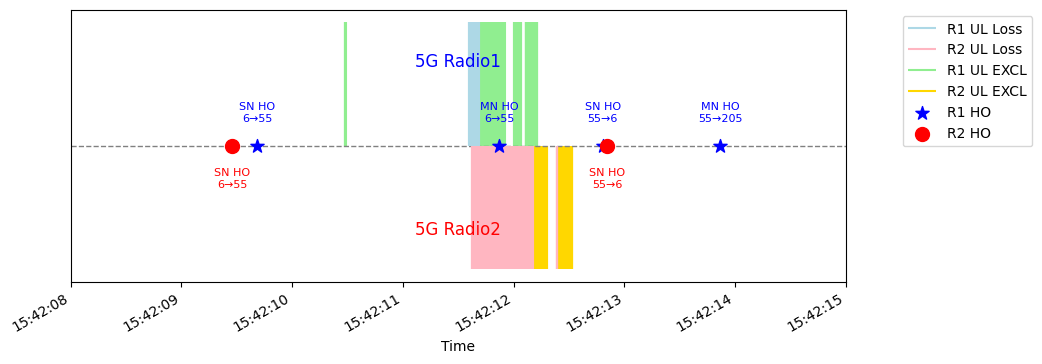

In [160]:
T1, Type1, Trans1, Ev1 = get_info(ordered_HOs1, time_range)
T2, Type2, Trans2, Ev2 = get_info(ordered_HOs2, time_range)

fig, ax = plt.subplots(figsize=(10, 4)) 
HO_SCA1 = ax.scatter(T1, [1] * len(T1), marker='*', color='b', s=100, zorder=3, label='R1 HO')
HO_SCA2 = ax.scatter(T2, [1] * len(T2), marker='o', color='r', s=100, zorder=3, label='R2 HO')

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)

for event, type, trans in zip(T1, Type1, Trans1):
    if type in ['LTE HO', 'MN HO']:
        # continue
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type in ['RLF II']:
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type == 'MN HO to eNB':
        trans = trans.split(' | ')[0]
        text = 'MN HO\nto eNB'+ '\n' + get_pci(trans, 'eNB HO')
    elif type in ['SN HO']:
        # continue
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB HO')
    elif type == 'SN setup':
        continue
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB setup')
    elif type == 'Conn Req':
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type == 'SCG RLF':
        continue
        text = 'SCG\nRLF'
    elif type == 'SN Rel':
        # continue
        text = 'SN\nRel' + '\n' + get_pci(trans, 'gNB rel')
    
    plt.text(event, 1.01, text, ha='center', va='bottom', fontsize=8, color='b', zorder=3)

for event, type, trans in zip(T2, Type2, Trans2):
    if type in ['LTE HO', 'MN HO']:
        # continue
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type in ['RLF II']:
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type == 'MN HO to eNB':
        # continue
        trans = trans.split(' | ')[0]
        text = 'MN HO\nto eNB'+ '\n' + get_pci(trans, 'eNB HO')
    elif type in ['SN HO']:
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB HO')
    elif type == 'SN setup':
        continue
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB setup')
    elif type == 'Conn Req':
        text = type + '\n' + get_pci(trans, 'eNB HO')
    elif type == 'SCG RLF':
        text = 'SCG\nRLF'
    elif type == 'SN Rel':
        text = 'SN\nRel' + '\n' + get_pci(trans, 'gNB rel')
        
    plt.text(event, 0.99, text, ha='center', va='top', fontsize=8, color='r', zorder=3)


# plt.title('Events of Radio1 & Radio2')
ax.set_xlabel('Time')
ax.set_yticks([])
ax.set_xlim((start_time, end_time))

x_range = ax.get_xlim()
x_range = [dates.num2date(n).replace(tzinfo=None) for n in x_range]
y_range = ax.get_ylim()

ax.text((x_range[1] - x_range[0])*1/2+x_range[0], (y_range[1] - y_range[0])*4.2/5+y_range[0],  
        '5G Radio1', ha='center', va='center', fontsize=12, color='b', zorder=5)
ax.text((x_range[1] - x_range[0])*1/2+x_range[0], (y_range[1] - y_range[0])*0.8/5+y_range[0], 
        '5G Radio2', ha='center', va='center', fontsize=12, color='r', zorder=5)

L1 = [pkg.timestamp for pkg in dl_loss1]
L2 = [pkg.timestamp for pkg in dl_loss2]
DL_LOSS1 = ax.vlines(x=L1, ymin=1, ymax=y_range[1], alpha=1, zorder=2, colors='lightblue', label='R1 DL Loss')
DL_LOSS2 = ax.vlines(x=L2, ymin= y_range[0], ymax=1, alpha=1, zorder=2, colors='lightpink', label='R2 DL Loss')

L3 = [pkg.timestamp for pkg in dl_excl1]
L4 = [pkg.timestamp for pkg in dl_excl2]
DL_EXCL1 = ax.vlines(x=L3, ymin=1, ymax=y_range[1], alpha=1, zorder=1, colors='lightgreen', label='R1 DL EXCL')
DL_EXCL2 = ax.vlines(x=L4, ymin=y_range[0], ymax=1, alpha=1, zorder=1, colors='gold', label='R2 DL EXCL')

# L5 = [pkg.timestamp for pkg in ul_loss1]
# L6 = [pkg.timestamp for pkg in ul_loss2]
# UL_LOSS1 = ax.vlines(x=L5, ymin=1, ymax=y_range[1], alpha=1, zorder=2, colors='lightblue', label='R1 UL Loss')
# UL_LOSS2 = ax.vlines(x=L6, ymin= y_range[0], ymax=1, alpha=1, zorder=2, colors='lightpink', label='R2 UL Loss')

# L7 = [pkg.timestamp for pkg in ul_excl1]
# L8 = [pkg.timestamp for pkg in ul_excl2]
# UL_EXCL1 = ax.vlines(x=L7, ymin=1, ymax=y_range[1], alpha=1, zorder=1, colors='lightgreen', label='R1 UL EXCL')
# UL_EXCL2 = ax.vlines(x=L8, ymin=y_range[0], ymax=1, alpha=1, zorder=1, colors='gold', label='R2 UL EXCL')

# Add Signal Strength
# ax2 = ax.twinx()
# R1_PCell_RSRP_PLOT = ax2.plot([ss.Timestamp for ss in R1_PCell], [ss.RSRP for ss in R1_PCell], 
#                             zorder=1, label='R1 RSRP', linestyle='--')[0]
# R2_PCell_RSRP_PLOT = ax2.plot([ss.Timestamp for ss in R2_PCell], [ss.RSRP for ss in R2_PCell], 
#                             zorder=1, label='R2 RSRP', linestyle='--')[0]

# R1_PSCell_RSRP_PLOT = ax2.plot([ss.Timestamp for ss in R1_PSCell], [ss.RSRP for ss in R1_PSCell], 
#                             zorder=1, label='R1 NR RSRP', linestyle='--')[0]
# R2_PSCell_RSRP_PLOT = ax2.plot([ss.Timestamp for ss in R2_PSCell], [ss.RSRP for ss in R2_PSCell], 
#                             zorder=1, label='R2 NR RSRP', linestyle='--')[0]

# R1_PCell_RSRQ_PLOT = ax2.plot([ss.Timestamp for ss in R1_PCell], [ss.RSRQ for ss in R1_PCell], 
#                             zorder=1, label='R1 RSRQ', linestyle='--')[0]
# R2_PCell_RSRQ_PLOT = ax2.plot([ss.Timestamp for ss in R2_PCell], [ss.RSRQ for ss in R2_PCell], 
#                             zorder=1, label='R2 RSRQ', linestyle='--')[0]

# R1_PSCell_RSRQ_PLOT = ax2.plot([ss.Timestamp for ss in R1_PSCell], [ss.RSRQ for ss in R1_PSCell], 
#                             zorder=1, label='R1 NR RSRQ', linestyle='--')[0]
# R2_PSCell_RSRQ_PLOT = ax2.plot([ss.Timestamp for ss in R2_PSCell], [ss.RSRQ for ss in R2_PSCell], 
#                             zorder=1, label='R2 NR RSRQ', linestyle='--')[0]

# ax2.set_ylabel('dBm')
# ax2.set_ylabel('dB')
# y2_range = ax2.get_ylim()

# Add text of Radio Name 
# ax2.text((x_range[1] - x_range[0])*1/2+x_range[0], (y2_range[1] - y2_range[0])*4/5+y2_range[0],  
#         '5G Radio1', ha='center', va='center', fontsize=12, color='b', zorder=5)
# ax2.text((x_range[1] - x_range[0])*1/2+x_range[0], (y2_range[1] - y2_range[0])*1/5+y2_range[0], 
#         '5G Radio2', ha='center', va='center', fontsize=12, color='r', zorder=5)

# Legend
# ax.legend(handles = [LOSS1, LOSS2], loc='upper right', bbox_to_anchor=(1.25, 1))
# ax.legend(handles = [DL_LOSS1, DL_LOSS2, DL_EXCL1, DL_EXCL2, HO_SCA1, HO_SCA2], loc='upper right', bbox_to_anchor=(1.25, 1))
ax.legend(handles = [UL_LOSS1, UL_LOSS2, UL_EXCL1, UL_EXCL2, HO_SCA1, HO_SCA2], loc='upper right', bbox_to_anchor=(1.25, 1))
# ax2.legend(handles= [R1_PCell_RSRP_PLOT, R2_PCell_RSRP_PLOT], loc='lower right', bbox_to_anchor=(1.25, 0))
# ax2.legend(handles= [R1_PSCell_RSRP_PLOT, R2_PSCell_RSRP_PLOT], loc='lower right', bbox_to_anchor=(1.25, 0))
# ax2.legend(handles= [R1_PCell_RSRP_PLOT, R2_PCell_RSRP_PLOT, R1_PSCell_RSRP_PLOT, R2_PSCell_RSRP_PLOT], loc='lower right', bbox_to_anchor=(1.25, 0))
# ax2.legend(handles= [R1_PCell_RSRQ_PLOT, R2_PCell_RSRQ_PLOT, R1_PSCell_RSRQ_PLOT, R2_PSCell_RSRQ_PLOT], loc='lower right', bbox_to_anchor=(1.25, 0))


myFmt = mdates.DateFormatter('%H:%M:%S') # fmt %H:%M:%S.%f
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()

plt.show()
